In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dataPath_surprise = 'drive/My Drive/ml/Cohn-Kanade/surprise'
dataPath_happy    = 'drive/My Drive/ml/Cohn-Kanade/happy'
dataPath_neutral  = 'drive/My Drive/ml/Cohn-Kanade/neutral'
dataPath_disgust  = 'drive/My Drive/ml/Cohn-Kanade/disgust'

In [ ]:
dataPath_surprise = 'drive/My Drive/CVLab/LAB1/Data/Cohn-Kanade/surprise'
dataPath_happy = 'drive/My Drive/CVLab/LAB1/Data/Cohn-Kanade/happy'
dataPath_neutral = 'drive/My Drive/CVLab/LAB1/Data/Cohn-Kanade/neutral'
dataPath_disgust  = 'drive/My Drive/CVLab/LAB1/Data/Cohn-Kanade/disgust'

In [3]:
import os
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from random import randrange
import random
from sklearn.model_selection import GridSearchCV
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

در قسمت زیر، تصاویر مجموعه های خنثی، خوشحال و متعحب و متنفرخوانده می شوند و به همراه برچسب های آن ها ذخیره می شوند.

In [4]:
data_neutral = []
labels_neutral = []

data_happy = []
labels_happy = []

data_surprise = []
labels_surprise = []

data_disgust = []
labels_disgust = []

for file in os.listdir(dataPath_surprise):
        if file[-3:] in {'jpg', 'png'}:
              im = imread(dataPath_surprise +'/' + file,0) # read image
              data_surprise.append((im.reshape(im.shape[0]*im.shape[1])))
              labels_surprise.append('surprise')
                    
for file in os.listdir(dataPath_happy):
        if file[-3:] in {'jpg', 'png'}:
              im = imread(dataPath_happy +'/' + file,0) # read image
              data_happy.append((im.reshape(im.shape[0]*im.shape[1])))
              labels_happy.append('happy')

for file in os.listdir(dataPath_neutral):
        if file[-3:] in {'jpg', 'png'}:
              im = imread(dataPath_neutral +'/' + file,0) # read image
              data_neutral.append((im.reshape(im.shape[0]*im.shape[1])))
              labels_neutral.append('neutral')

for file in os.listdir(dataPath_disgust):
        if file[-3:] in {'jpg', 'png'}:
              im = imread(dataPath_disgust +'/' + file,0) # read image
              data_disgust.append((im.reshape(im.shape[0]*im.shape[1])))
              labels_disgust.append('disgust')

در قسمت زیر، به ترتیب از هر کدام از مجموعه های خنثی، خوشحال و سورپرایز و متنفر، ۱۲۰، ۶۰ ، ۶۰ ، ۳۰ تصویر به صورت رندم به عنوان تصاویر آموزش و مابقی تصاویر به عنوان تصاویو تست جدا می شوند.

In [5]:
# train test split
X_train_surprise, X_test_surprise, y_train_surprise, y_test_surprise = train_test_split(data_surprise, labels_surprise ,train_size=60 ,random_state=42)
X_train_happy   , X_test_happy   , y_train_happy   , y_test_happy    = train_test_split(data_happy,    labels_happy    ,train_size=60 ,random_state=42)
X_train_neutral , X_test_neutral , y_train_neutral , y_test_neutral  = train_test_split(data_neutral,  labels_neutral  ,train_size=120,random_state=42)
X_train_disgust , X_test_disgust , y_train_disgust , y_test_disgust  = train_test_split(data_disgust,  labels_disgust  ,train_size=30 ,random_state=42)

In [6]:
X_train_total = X_train_surprise + X_train_happy + X_train_neutral + X_train_disgust
y_train_total = y_train_surprise + y_train_happy + y_train_neutral + y_train_disgust
X_test_total = X_test_surprise + X_test_happy + X_test_neutral + X_test_disgust
y_test_total = y_test_surprise + y_test_happy + y_test_neutral + y_test_disgust

در قسمت زیر، الگوریتم پی سی ای با ۳۰ مولفه اساسی روی داده های آموزش ترین می شود و سپس با استقاه از آن، داده های آموزش و تست کاهش بعد داده می شوند.

In [7]:
# training PCA
pca = PCA(n_components=30)
pca.fit(X_train_total)
X_reduced_train=(pca.transform(X_train_total))
X_reduced_test=(pca.transform(X_test_total))
print('Shape of the reduced train data: ', np.shape(X_reduced_train))
print('Shape of the reduced test data: ', np.shape(X_reduced_test))

Shape of the reduced train data:  (270, 30)
Shape of the reduced test data:  (140, 30)


In [ ]:
Xtrain_reduced_surprise = X_reduced_train[0:60]
Xtrain_reduced_happy = X_reduced_train[60:120]
Xtrain_reduced_netral = X_reduced_train[120:240]

Xtest_reduced_surprise = X_reduced_train[0:60]
Xtest_reduced_happy = X_reduced_train[60:120]
Xtest_reduced_netral = X_reduced_train[120:240]

در بخش زیر، تابعی برای کراس ولیدیشن تعریف کردیم. این تابع در ورودی، داده ها را به همراه لیبل های آن، تعداد فولدها و تابع تخمین میگیرد. سپس  داده را شافل می کند. در ادامه با بخش بندی کردن دیتای شافل شده، هر بار یکی از بخش ها به عنوان داده ولیدیشن در نظر گرفته می شود و کا منهای یک بخش دیگر به عنوان داده آموزش.  برای هر کدام یک از حالت ها، الگوریتم داده شده روی داده آموزش ترین می شود و درستی آن روی داده ولیدیشن حساب می شود. سپس میانگین عملکرد تابع تخمین به ازای همه حالت ها به دست می آید و در خروجی تابع قرار می گیرد.

In [10]:
def cross_validation(X, y, k, estimator):
  fold_size = int(len(X)/k)
  index_range = np.arange(0, len(X))
  random.shuffle(index_range)
  X_shuffled = [X[i] for i in index_range]
  y_shuffled = [y[i] for i in index_range]
  acc = 0
  for i in range(k):
    X_train_fold = X_shuffled[0:i*fold_size] + X_shuffled[(i+1)*fold_size:]
    y_train_fold = y_shuffled[0:i*fold_size] + y_shuffled[(i+1)*fold_size:]
    X_val_fold = X_shuffled[i*fold_size:(i+1)*fold_size]
    y_val_fold = y_shuffled[i*fold_size:(i+1)*fold_size]

    estimator.fit(X_train_fold, y_train_fold)
    acc = acc + estimator.score(X_val_fold, y_val_fold)
  acc = acc/k
  return acc

در این آزمایش ۳ کلاس وجود دارد. طبق خواسته سوال می بایست طبقه بندهای جداگانه بین هر کلاس و بقیه حالت ها ساخته شود. بدین منظور سه طبقه بند ساخته شده که خروجی طبقه بند اول، احتمال تعلق به کلاس متعجب را نشان می دهد. خروجی طبقه بند دوم، احتمال تعلق به کلاس خوشحال و خروجی طبقه بند سوم، احتمال تعلق به کلاس خنثی را نشان می دهد. آموزش هر طبقه بند با استفاده از کراس ولیدیشن و به ازای پارامترهای مختلف سی انجام می شود.

### "Surprise vs others" classifier:

In [ ]:
# training SVM
C=np.logspace(-5,5,21)
C = [0.0001 ,0.01, 0.1, 1, 10]
for c in C:
  accuracies = []
  clf_surprise = make_pipeline(StandardScaler(),LinearSVC(C=c, dual=False))
  y_train_surprise = np.array(y_train_total)=='surprise'
  accuracy = cross_validation(X_reduced_train, y_train_surprise, 5, clf_surprise)
  print('Train Accuracy for C=', c, ': ', accuracy)
  accuracies.append(accuracy)

Train Accuracy for C= 0.0001 :  0.9444444444444444
Train Accuracy for C= 0.01 :  0.9407407407407407
Train Accuracy for C= 0.1 :  0.9407407407407407
Train Accuracy for C= 1 :  0.9222222222222223
Train Accuracy for C= 10 :  0.9074074074074072


همان طور که دیده می شود، به ازای c=1 بهترین نتیجه را داریم.

In [ ]:
best_clf_surprise =LinearSVC(C=1, dual=False)
best_clf_surprise.fit(X_reduced_train, y_train_surprise)

LinearSVC(C=1, dual=False)

In [ ]:
# testing
y_test_surprise = np.array(y_test_total)=='surprise' # true labels for "surprise vs others"
y_test_surprise_predicted = best_clf_surprise.predict(X_reduced_test) # predicted labels

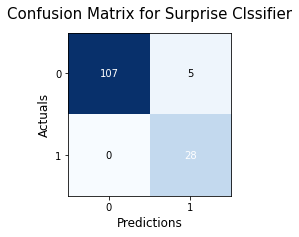

In [ ]:
# printing confusion matrix
conf_mat = confusion_matrix(y_test_surprise, y_test_surprise_predicted)
fig, ax = plot_confusion_matrix(conf_mat=conf_mat, figsize=(3, 3), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title('Confusion Matrix for Surprise Clssifier', fontsize=15)
plt.show()

همان طور که از ماتریس درهم ریختگی بالا دیده می شود، از 112 داده که لیبل صفر داشتند، 107 داده به درستی طبقه بندی شده اند. از ۲۸ داده که لیبل یک داشتند، همگی  داده به درستی طبقه بندی شدند.

In [ ]:
print('Accuracy of the Surprise classifier on the test data: ', best_clf_surprise.score(X_reduced_test, y_test_surprise))

Accuracy of the Surprise classifier on the test data:  0.9642857142857143


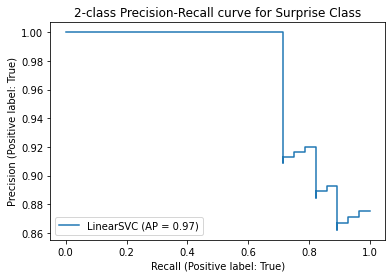

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay
display = PrecisionRecallDisplay.from_estimator(
    best_clf_surprise, X_reduced_test, y_test_surprise)
_ = display.ax_.set_title("2-class Precision-Recall curve for Surprise Class")

در قسمت های زیر، به طرق مشابه باقی طبقه بندها آموزش و تست شده اند.

### "Happy vs others" classifier:

In [ ]:
# training SVM
C = [0.001 ,0.01, 0.1, 1, 10,100]
for c in C:
  accuracies = []
  clf_happy = make_pipeline(StandardScaler(),LinearSVC(C=c, dual=False))
  y_train_happy = np.array(y_train_total)=='happy'
  accuracy = cross_validation(X_reduced_train, y_train_happy, 5, clf_surprise)
  print('Train Accuracy for C=', c, ': ', accuracy)
  accuracies.append(accuracy)

Train Accuracy for C= 0.001 :  0.9037037037037037
Train Accuracy for C= 0.01 :  0.9074074074074072
Train Accuracy for C= 0.1 :  0.9111111111111111
Train Accuracy for C= 1 :  0.9074074074074074
Train Accuracy for C= 10 :  0.8925925925925927
Train Accuracy for C= 100 :  0.874074074074074


همان طور که دیده می شود، به ازای c=0.1 بهترین نتیجه را داریم.

In [ ]:
best_clf_happy =LinearSVC(C=0.1, dual=False)
best_clf_happy.fit(X_reduced_train, y_train_happy)

LinearSVC(C=0.1, dual=False)

In [ ]:
# testing
y_test_happy = np.array(y_test_total)=='happy' # true labels for "surprise vs others"
y_test_happy_predicted = best_clf_happy.predict(X_reduced_test) # predicted labels

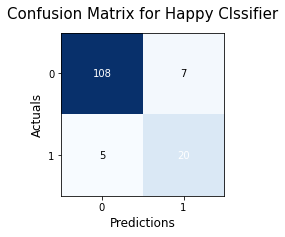

In [ ]:
# printing confusion matrix
conf_mat = confusion_matrix(y_test_happy, y_test_happy_predicted)
fig, ax = plot_confusion_matrix(conf_mat=conf_mat, figsize=(3, 3), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title('Confusion Matrix for Happy Clssifier', fontsize=15)
plt.show()

همان طور که از ماتریس درهم ریختگی بالا دیده می شود، از 115 داده که لیبل صفر داشتند، 108 داده به درستی طبقه بندی شده اند. از ۲۵ داده که لیبل ۱ داشتند، ۲۰ داده به درستی طبقه بندی شدند.

In [ ]:
print('Accuracy of the Surprise classifier on the test data: ', best_clf_happy.score(X_reduced_test, y_test_happy))

Accuracy of the Surprise classifier on the test data:  0.9142857142857143


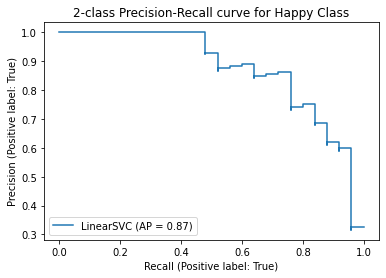

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay
display = PrecisionRecallDisplay.from_estimator(
    best_clf_happy, X_reduced_test, y_test_happy)
_ = display.ax_.set_title("2-class Precision-Recall curve for Happy Class")

### "Neutral vs others" classifier:

In [17]:
# training SVM
C = [0.001 ,0.01, 0.1, 1, 10,100]
for c in C:
  accuracies = []
  clf_neutral = make_pipeline(StandardScaler(),LinearSVC(C=c, dual=False))
  y_train_neutral = np.array(y_train_total)=='neutral'
  accuracy = cross_validation(X_reduced_train, y_train_neutral, 5, clf_neutral)
  print('Train Accuracy for C=', c, ': ', accuracy)
  accuracies.append(accuracy)

Train Accuracy for C= 0.001 :  0.7666666666666667
Train Accuracy for C= 0.01 :  0.7962962962962963
Train Accuracy for C= 0.1 :  0.7851851851851852
Train Accuracy for C= 1 :  0.8185185185185185
Train Accuracy for C= 10 :  0.8
Train Accuracy for C= 100 :  0.8037037037037036


همان طور که دیده می شود، به ازای c=1 بهترین نتیجه را داریم.

In [18]:
best_clf_neutral =LinearSVC(C=1, dual=False)
best_clf_neutral.fit(X_reduced_train, y_train_neutral)

LinearSVC(C=1, dual=False)

In [19]:
# testing
y_test_neutral = np.array(y_test_total)=='neutral' # true labels for "surprise vs others"
y_test_neutral_predicted = best_clf_neutral.predict(X_reduced_test) # predicted labels

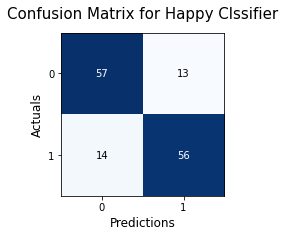

In [20]:
# printing confusion matrix
conf_mat = confusion_matrix(y_test_neutral, y_test_neutral_predicted)
fig, ax = plot_confusion_matrix(conf_mat=conf_mat, figsize=(3, 3), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title('Confusion Matrix for Happy Clssifier', fontsize=15)
plt.show()

همان طور که از ماتریس درهم ریختگی بالا دیده می شود، از 70 داده که لیبل صفر داشتند، 56 داده به درستی طبقه بندی شده اند. از 70 داده که لیبل ۱ داشتند، 55 داده به درستی طبقه بندی شدند.

In [21]:
print('Accuracy of the Surprise classifier on the test data: ', best_clf_neutral.score(X_reduced_test, y_test_neutral))

Accuracy of the Surprise classifier on the test data:  0.8071428571428572


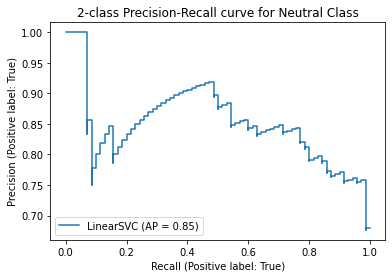

In [22]:
from sklearn.metrics import PrecisionRecallDisplay
display = PrecisionRecallDisplay.from_estimator(
    best_clf_neutral, X_reduced_test, y_test_neutral)
_ = display.ax_.set_title("2-class Precision-Recall curve for Neutral Class")

# multi-class svm 

در قسمت های پیشین برای هر کلاس یک جداکننده جدا اجرا کردیم و خطوط متناظر را بدست آوردیم. در این قسمت از این روش در حالت طبقه بند چند کلاسه استفاده می کنیم به این صورت که برای هر کلاس یک جداکننده پیدا می کنیم که آن را از بقیه جدا کند. سپس برای داده تست فاصله هر دیتا از هر کدام از این خطوط بیشتر باشد یعنی با اطمینان بیشتری لیبل مشابه با آن جداکننده داردو به این ترتیب لیبل ها را اختصاص می دهیم.


In [8]:
clf = make_pipeline(StandardScaler(), LinearSVC())
clf.fit(X_reduced_train, y_train_total)
y_test_predicted = clf.predict(X_reduced_test) # predicted labels
#print(y_test_predicted)
print(clf[1].coef_)
print('test  accuracy:',clf.score(X_reduced_test,y_test_total))
print('train accuracy:',clf.score(X_reduced_train,y_train_total))

[[-0.01000397  0.02613897  0.37321126 -0.18729366 -0.13012975 -0.06163858
  -0.1773594   0.07774493 -0.06859533  0.01444542  0.10038733  0.20636304
  -0.24297743  0.04727492 -0.30270201 -0.19597876 -0.08913685 -0.00695831
   0.30481017  0.01595194  0.37801755  0.00509117  0.00184237 -0.03781523
  -0.2552576   0.05899315  0.04651213 -0.1697261  -0.06008242 -0.32238152]
 [-0.20691829  0.22844185 -0.51392002  0.13909794 -0.19182512  0.09624524
   0.28995483  0.14595352  1.21115616 -0.12740193 -0.63410414  0.22336756
  -0.8846998   0.11761547 -0.99277646  0.01483689  0.09382242  0.08880395
  -0.22397602  0.87107351 -0.02333075 -0.16527538  0.08539316  0.15795181
   0.22249492  0.06382663  0.84855136  0.01540879  0.64846391  0.00841826]
 [-0.05414676  0.15397512 -0.08135607  0.25782659 -0.02466238 -0.21663789
   0.08631973  0.09317005  0.05826305 -0.0648717  -0.35437027 -0.05965781
  -0.20200111  0.36162924  0.39488327 -0.16069417  0.18561059  0.01115272
  -0.14737553 -0.85699298 -0.573848 

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



در اینجا همانطور که انتظار می رفت جداکننده 4 خط متفاوت است و لذا 4 بردار ضریب در خروجی خواهیم داشت. در این حالت داده ترین با دقت 90 درصد و داده تست با دقت 81 درصد به درستی لیبل گذاری می شوند. 

توجه داریم برای رسیدن به دقت بالاتر باید تعداد مولفه بیشتری در الگوریتم کاهش بعد نگهداری کنیم.

In [11]:
# training SVM
C = [0.001 ,0.01, 0.1, 1, 10,100]
for c in C:
  accuracies = []
  clf_total = make_pipeline(StandardScaler(), LinearSVC(C=c))
  accuracy = cross_validation(X_reduced_train, y_train_total, 5, clf_total)
  #accuracy =cross_val_score(clf_total,X_reduced_train, y_train_total, cv= 5).mean()
  print('Train Accuracy for C=', c, ': ', accuracy)
  accuracies.append(accuracy)

Train Accuracy for C= 0.001 :  0.7592592592592593
Train Accuracy for C= 0.01 :  0.774074074074074
Train Accuracy for C= 0.1 :  0.7333333333333332
Train Accuracy for C= 1 :  0.7666666666666667


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

Train Accuracy for C= 10 :  0.7518518518518518
Train Accuracy for C= 100 :  0.725925925925926


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

در این قسمت سعی می کنیم پارامتر سی را طوری تعیین کنیم که بهینه ترین عملکرد را داشته باشد. همانطور که مشاهده شد این مقدار 0.1 می باشد.

In [23]:
clf = make_pipeline(StandardScaler(), LinearSVC(C=0.1))
clf.fit(X_reduced_train, y_train_total)
y_test_predicted = clf.predict(X_reduced_test) # predicted labels
#print(y_test_predicted)
#print(clf[1].coef_)
print('test  accuracy:',clf.score(X_reduced_test,y_test_total))
print('train accuracy:',clf.score(X_reduced_train,y_train_total))

test  accuracy: 0.8214285714285714
train accuracy: 0.8740740740740741


مشاهده می کنیم خطای ترین کمی بدتر شده است ولی در مقابل خطا تست بهتر شده است.

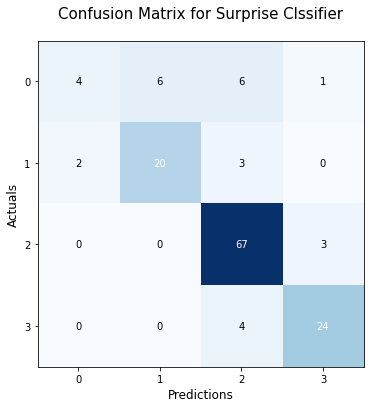

In [24]:
conf_mat = confusion_matrix(y_test_total, y_test_predicted)
fig, ax = plot_confusion_matrix(conf_mat=conf_mat, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title('Confusion Matrix for Surprise Clssifier', fontsize=15)
plt.show()

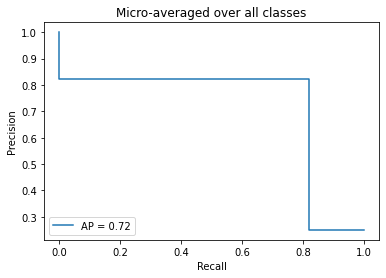

In [31]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

# For each class
precision = dict()
recall = dict()
average_precision = dict()

Y_test = label_binarize(y_test_total, classes=['surprise','happy', 'neutral', 'disgust'])
Y_predicted = label_binarize(y_test_predicted, classes=['surprise','happy', 'neutral', 'disgust'])

for i in range(4):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], Y_predicted[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], Y_predicted[:, i])

precision["micro"], recall["micro"], _ = precision_recall_curve(
    Y_test.ravel(), Y_predicted.ravel()
)
average_precision["micro"] = average_precision_score(Y_test, Y_predicted, average="micro")

# plotting
display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot()
_ = display.ax_.set_title("Micro-averaged over all classes")

# Section 2

در این قسمت از کرنل غیرخطی استفاده میکنیم. با استفاده از گرید سرچ، برای هر حالت، بهترین پارامترها را برای سی و سیگمای کرنل گوسی به دست می آوریم. 

### "Surprise vs others" classifier:

In [ ]:
# Hyperparameter tunning using greed search
grid_param = {"C":  np.logspace(-5, 5, 11),
             "gamma": np.logspace(-10, 2, 13)}

grid_search_surprise = GridSearchCV(estimator = SVC(), param_grid = grid_param, return_train_score=True,
                          cv = 3, n_jobs = -1, verbose = 2)

# fitting the result of grid search on validation data
scale=StandardScaler()
scale.fit(X_reduced_train)
grid_search_surprise.fit(scale.transform(X_reduced_train), y_train_surprise)
print('Best parameters found the Surprise Classifier: ', grid_search_surprise.best_params_)

Fitting 3 folds for each of 143 candidates, totalling 429 fits
Best parameters found the Surprise Classifier:  {'C': 100.0, 'gamma': 0.001}


In [ ]:
clf = make_pipeline(StandardScaler(),SVC(C=100, gamma=0.001))
clf.fit(X_reduced_train, y_train_surprise)
y_test_predicted = clf.predict(X_reduced_test) # predicted labels

print('test  accuracy:',clf.score(X_reduced_test,y_test_surprise))
print('train accuracy:',clf.score(X_reduced_train,y_train_surprise))

test  accuracy: 0.9785714285714285
train accuracy: 0.9740740740740741


همانطور که مشاهده می کنیم دقت ما در حالت گوسی نسبت به خطی از 96 درصد به 97 درصد افزایش یافته است. که این نتیجه مورد انتظار است زیرا کرنل گوسی داده ها را در فضای بزرگتری از حالت خطی طبقه بندی می کند.

### "Happy vs others" classifier: 

In [ ]:
# Hyperparameter tunning using greed search
grid_param = {"C":  np.logspace(-5, 5, 11),
             "gamma": np.logspace(-10, 2, 13)}

grid_search_happy = GridSearchCV(estimator = SVC(), param_grid = grid_param, return_train_score=True,
                          cv = 3, n_jobs = -1, verbose = 2)

# fitting the result of grid search on validation data
scale=StandardScaler()
scale.fit(X_reduced_train)
grid_search_happy.fit(scale.transform(X_reduced_train), y_train_happy)
print('Best parameters found for the Happy Classifier: ', grid_search_happy.best_params_)

Fitting 3 folds for each of 143 candidates, totalling 429 fits
Best parameters found for the Happy Classifier:  {'C': 100000.0, 'gamma': 1e-07}


In [ ]:
clf = make_pipeline(StandardScaler(),SVC(C=100000, gamma=0.0000001))
clf.fit(X_reduced_train, y_train_happy)
y_test_predicted = clf.predict(X_reduced_test) # predicted labels

print('test  accuracy:',clf.score(X_reduced_test,y_test_happy))
print('train accuracy:',clf.score(X_reduced_train,y_train_happy))

test  accuracy: 0.9142857142857143
train accuracy: 0.9333333333333333


دقتی مشابه حالت خطی دارد.

### "Neutral vs others" classifier:

In [ ]:
# Hyperparameter tunning using greed search
grid_param = {"C":  np.logspace(-5, 5, 11),
             "gamma": np.logspace(-10, 2, 13)}

grid_search_neutral = GridSearchCV(estimator = SVC(), param_grid = grid_param, return_train_score=True,
                          cv = 3, n_jobs = -1, verbose = 2)

# fitting the result of grid search on validation data
scale=StandardScaler()
scale.fit(X_reduced_train)
grid_search_neutral.fit(scale.transform(X_reduced_train), y_train_neutral)
print('Best parameters found for the Happy Classifier: ', grid_search_neutral.best_params_)

Fitting 3 folds for each of 143 candidates, totalling 429 fits
Best parameters found for the Happy Classifier:  {'C': 10000.0, 'gamma': 0.0001}


In [ ]:
clf = make_pipeline(StandardScaler(),SVC(C=10000, gamma=0.0001))
clf.fit(X_reduced_train, y_train_neutral)
y_test_predicted = clf.predict(X_reduced_test) # predicted labels

print('test  accuracy:',clf.score(X_reduced_test,y_test_neutral))
print('train accuracy:',clf.score(X_reduced_train,y_train_neutral))

test  accuracy: 0.7928571428571428
train accuracy: 0.9111111111111111


دقتی مشابه حالت خطی دارد.

## multi-class svm

در این قسمت از این روش در حالت طبقه بند چند کلاسه استفاده می کنیم به این صورت که برای هر کلاس یک جداکننده پیدا می کنیم که آن را از بقیه جدا کند. سپس برای داده تست فاصله هر دیتا از هر کدام از این خطوط بیشتر باشد یعنی با اطمینان بیشتری لیبل مشابه با آن جداکننده داردو به این ترتیب لیبل ها را اختصاص می دهیم.


In [33]:
clf = make_pipeline(StandardScaler(),SVC(kernel='rbf',decision_function_shape='ovr'))
clf.fit(X_reduced_train, y_train_total)
y_test_predicted = clf.predict(X_reduced_test) # predicted labels

print('test  accuracy:',clf.score(X_reduced_test,y_test_total))
print('train accuracy:',clf.score(X_reduced_train,y_train_total))

test  accuracy: 0.7285714285714285
train accuracy: 0.8481481481481481


بدون ست کردن پارامتر ها ، خطای ترین و تست هردو از حالت خطی بدتر شده است. در ادامه با روش گرید سرچ این پارامتر ها را تعیین کرده و دقت را مجددا بررسی می کنیم

In [34]:
clf =SVC(decision_function_shape='ovr')
scale=StandardScaler()
scale.fit(X_reduced_train)
grid_param = {"C":  np.logspace(-5, 5, 11),
             "gamma": np.logspace(-10, 2, 13)}

grid_search_neutral = GridSearchCV(estimator = clf, param_grid = grid_param, return_train_score=True,
                          cv = 3, n_jobs = -1, verbose = 2)

# fitting the result of grid search on validation data
grid_search_neutral.fit(scale.transform(X_reduced_train), y_train_total)

print('Best parameters found for the Neutral Clssifier: ', grid_search_neutral.best_params_)

Fitting 3 folds for each of 143 candidates, totalling 429 fits
Best parameters found for the Neutral Clssifier:  {'C': 1000.0, 'gamma': 0.0001}


In [35]:
clf = make_pipeline(StandardScaler(),SVC(kernel='rbf',decision_function_shape='ovr',C=10, gamma=0.01))
clf.fit(X_reduced_train, y_train_total)
y_test_predicted = clf.predict(X_reduced_test) # predicted labels

print('test  accuracy:',clf.score(X_reduced_test,y_test_total))
print('train accuracy:',clf.score(X_reduced_train,y_train_total))

test  accuracy: 0.85
train accuracy: 0.9555555555555556


همانطور که مشاهده می کنیم دقت تست از 82 در صد در حالت خطی به 85 درصد افزایش یافته و دقت ترین هم از 90 در صد در حالت خطی به 97 درصد افزایش یافته است.

 این نتیجه مورد انتظار است زیرا کرنل گوسی داده ها را در فضای بزرگتری از حالت خطی طبقه بندی می کند.همچنین برای افزایش دقت می توان تعداد مولفه های بیشتری را در کاهش بعد نگه داشت.

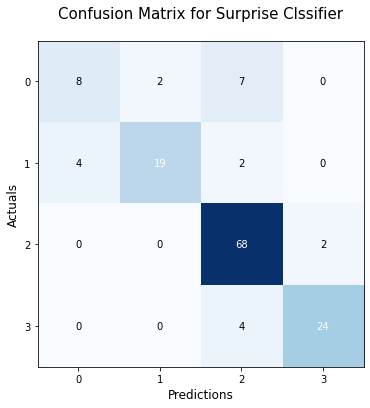

In [36]:
conf_mat = confusion_matrix(y_test_total, y_test_predicted)
fig, ax = plot_confusion_matrix(conf_mat=conf_mat, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title('Confusion Matrix for Surprise Clssifier', fontsize=15)
plt.show()

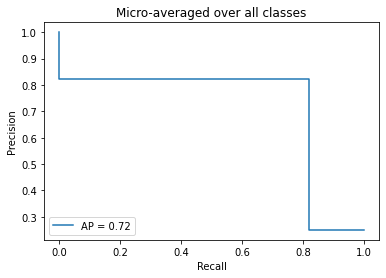

In [32]:
# For each class
precision = dict()
recall = dict()
average_precision = dict()

Y_test = label_binarize(y_test_total, classes=['surprise','happy', 'neutral', 'disgust'])
Y_predicted = label_binarize(y_test_predicted, classes=['surprise','happy', 'neutral', 'disgust'])

for i in range(4):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], Y_predicted[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], Y_predicted[:, i])

precision["micro"], recall["micro"], _ = precision_recall_curve(
    Y_test.ravel(), Y_predicted.ravel()
)
average_precision["micro"] = average_precision_score(Y_test, Y_predicted, average="micro")

# plotting
display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot()
_ = display.ax_.set_title("Micro-averaged over all classes")